<a href="https://colab.research.google.com/github/PedroPinheiroMachado/Portfolio/blob/main/An%C3%A1lise_de_Fraudes_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análise de Fraudes em Cartões de Crédito

Neste projeto iremos abordar o tema de fraudes nos cartões de crédito.

É um assunto de suma importância para as instituições financeiras, visto que são quantidades exorbitantes de reais.

Em 2024, o Indicador de Tentativas de Fraude da Serasa Experian aponta que as tentativas de fraude bancária, incluindo cartões, `aumentaram 10,4%` em comparação com 2023. Se as fraudes concretizassem, o prejuízo estimado seria de `R$ 51,6 bilhões`.

Além disso, estudos da Serasa Experian revelam que `4 em cada 10 brasileiros` já foram vítimas de alguma fraude, com prejuízos médios de `R$ 2.288`.

Assim, é importante conseguir diferenciar uma tentativa verdadeira de uma tentativa fraudulenta. Dessa forma, esse projeto tem como foco, apresentar um modelo capaz de julgar novos dados de forma a ter a maior segurança possível.





## Importando os Dados
[Página dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud)

Os dados que usaremos neste projeto foram disponibilizados no kaggle por algumas empresas européias de cartão de crédito. O *dataset* apresenta 2 dias de operações ocorridas em setembro de 2013. Sendo 492 fraudulentas de 284.807 transações.

Como podemos ver, é um cojunto de dados bastante desbalanceado, cerca de 0.172% operações de classe positiva (fraudulentas), teremos que dar uma atenção para esse fato, uma vez que nosso modelo pode ficar enviesado.

Esses dados passaram por um processo de Análise de Componentes Principais (*Principal Component Analysis* - PCA). Esta transformação permite diminuir a dimensionalidade dos dados mantendo o maior número de informações possíveis, assim todas as features são numéricas.

Uma última observação, os nomes das variáveis, sao $[V1,V2,V3...V28]$ uma vez que são dados sigilosos e precisam ser tratados como tais.



In [57]:
#Importando os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"
df = pd.read_csv(file_path)

##Variáveis

Perceba que `Time`, `Amount` e `Class` são diferentes das $[V1,..V28]$ (Variáveis de PCA)

`Time`: Conta o tempo em segundos desde a primeira transação.

`Amount`: É o valor da transação

`Class`: É o rótulo da transação, 0 = Boa, 1 = Fraudulenta

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


##Divisão treino e teste

Após a extração dos dados, faremos o processo da divisão do nosso *dataset*, em conjuntos de treino e teste com proporção 0.7/0.3,a fim de selecionar nosso modelo e verificar os resultados obtidos. Mais a frente separaremos o conjunto de validação para selecionar nossos hiperparametros


In [4]:
X=df.drop("Class",axis=1)
y=df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print("Tamanho do conjunto de treino: ",X_train.shape[0])
print("Tamanho do conjunto de teste: ",X_test.shape[0])

Tamanho do conjunto de treino:  199364
Tamanho do conjunto de teste:  85443


In [26]:
dftreino = pd.concat([X_train,y_train],axis=1)

## Análise exploratória dos dados

Nesta seção, faremos um estudo inicial sobre o comportamento dos dados, como desbalanceamento das classes, analisando gráficos e algumas estatísticas.

In [27]:
dftreino.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
70013,-0.866311,-0.385109,1.137025,1.301256,0.069402,0.121756,-0.964708,0.797031,-0.132699,-0.553466,...,-0.242003,-0.607338,0.007058,0.361068,-0.119296,0.068027,0.247068,0.102098,-0.295114,0
139952,-0.239316,1.213642,-1.697132,1.465902,-0.798272,-2.292196,0.342296,-1.633795,0.203595,-0.847239,...,-0.345696,-0.310778,-0.003590,0.571924,0.310792,-0.251832,0.086013,0.035827,-0.004065,0
16822,-1.402838,-1.540264,-0.768000,0.510664,-0.510481,3.836719,2.724136,-0.616586,0.726290,-0.518812,...,-0.258582,-0.986112,-0.077637,1.007465,0.207166,0.205286,-0.335809,0.059068,-0.339900,0
35464,-1.193623,0.890856,-0.984252,0.869886,0.668964,-1.404565,-0.122204,-0.546233,0.006776,-0.848480,...,-0.059964,0.060502,-0.207493,0.544251,0.426205,-0.273934,0.045311,0.059008,0.402171,0
38360,-1.167615,1.306242,0.733721,-0.741451,1.119065,0.599208,-0.678050,0.323355,-0.210136,-0.095776,...,-0.126074,-0.262032,-0.249106,-0.706469,0.836472,-0.268833,0.037055,0.048678,-0.350266,0


In [28]:
dftreino.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159491 entries, 70013 to 73149
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    159491 non-null  float64
 1   V1      159491 non-null  float64
 2   V2      159491 non-null  float64
 3   V3      159491 non-null  float64
 4   V4      159491 non-null  float64
 5   V5      159491 non-null  float64
 6   V6      159491 non-null  float64
 7   V7      159491 non-null  float64
 8   V8      159491 non-null  float64
 9   V9      159491 non-null  float64
 10  V10     159491 non-null  float64
 11  V11     159491 non-null  float64
 12  V12     159491 non-null  float64
 13  V13     159491 non-null  float64
 14  V14     159491 non-null  float64
 15  V15     159491 non-null  float64
 16  V16     159491 non-null  float64
 17  V17     159491 non-null  float64
 18  V18     159491 non-null  float64
 19  V19     159491 non-null  float64
 20  V20     159491 non-null  float64
 21  V21     1594

In [29]:
dftreino.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,159491.000000,159491.000000,159491.000000,159491.000000,159491.000000,159491.000000,159491.000000,159491.000000,159491.000000,159491.000000,...,159491.000000,159491.000000,159491.000000,159491.000000,159491.000000,159491.000000,159491.000000,159491.000000,159491.000000,159491.000000
mean,-0.001964,-0.006654,-0.003401,-0.001325,0.000065,0.002482,0.005277,-0.001271,-0.000943,-0.000412,...,-0.000749,-0.000359,0.000281,0.001480,0.000525,-0.000295,0.000704,-0.000621,0.001893,0.001668
std,0.999103,1.962156,1.655711,1.521009,1.418534,1.400183,1.345695,1.259330,1.211083,1.098259,...,0.747721,0.726853,0.629682,0.606225,0.521959,0.482000,0.402960,0.330148,1.020979,0.040805
min,-1.996561,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-50.943369,-13.320155,...,-22.797604,-9.499423,-44.807735,-2.836627,-10.295397,-2.604551,-9.895244,-15.430084,-0.354269,0.000000
25%,-0.855687,-0.926038,-0.599621,-0.890538,-0.844309,-0.689850,-0.768534,-0.556056,-0.208429,-0.642788,...,-0.228827,-0.543319,-0.161680,-0.353608,-0.316732,-0.326999,-0.070821,-0.053069,-0.331696,0.000000
50%,-0.215120,0.011745,0.063974,0.179165,-0.019763,-0.051243,-0.272614,0.039402,0.022644,-0.051116,...,-0.030212,0.005395,-0.010613,0.041471,0.018932,-0.051983,0.001281,0.011293,-0.265937,0.000000
75%,0.936125,1.314503,0.800939,1.025322,0.741442,0.616933,0.405761,0.570082,0.330682,0.596990,...,0.186083,0.527395,0.147297,0.441897,0.351565,0.240772,0.091124,0.077891,-0.043288,0.000000
max,1.642089,2.454930,22.057729,4.187811,16.875344,34.801666,73.301626,120.589494,19.587773,10.326133,...,27.202839,8.316275,22.528412,4.584549,6.070850,3.415636,31.612198,33.847808,102.470107,1.000000


### Contagem de Classes

Como ja dito antes, podemos ver que nossos dados estão desbalanceados

In [30]:
round(dftreino['Class'].value_counts()/df.shape[0],5)

,count
Class,
0,0.55906
1,0.00093


[]

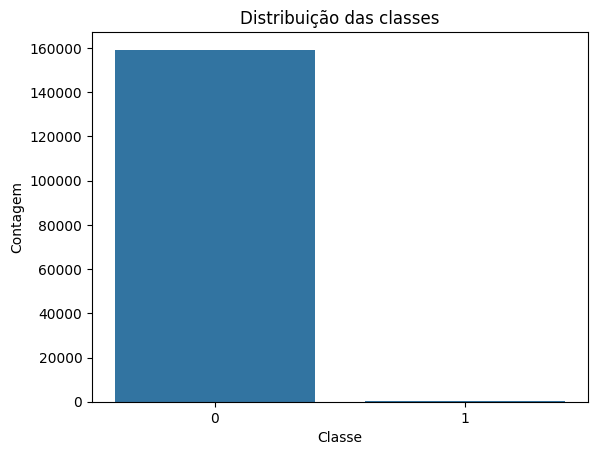

In [31]:
fig, ax = plt.subplots()
sns.countplot(x="Class", data=dftreino, ax=ax)
ax.set_title("Distribuição das classes")
ax.set_xlabel("Classe")
ax.set_ylabel("Contagem")
plt.plot()

###Time

Perceba que os histogramas diferem bastante, enquanto as transações normais ocorrem em um padrão, transações fraudulentas possuem picos espalhados de acordo com os horários.


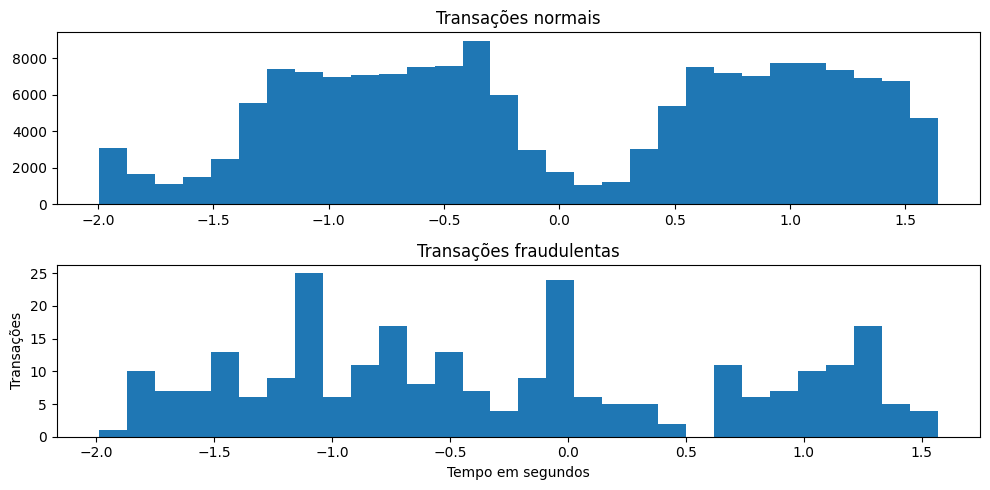

In [33]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,5))
numbins=30
ax[0].hist(dftreino.Time[dftreino.Class==0],bins=numbins)
ax[0].set_title("Transações normais")
ax[1].hist(dftreino.Time[dftreino.Class==1],bins=numbins)
ax[1].set_title("Transações fraudulentas")
plt.xlabel('Tempo em segundos')
plt.ylabel('Transações')
plt.tight_layout()
plt.show()

###Amount

Perceba, também, que as transações fraudulentas possuem em médias valores maiores do que as normais.

In [34]:
print("média das transações normais:",round(dftreino.Amount[dftreino.Class==0].mean(),2))
print("média das transações fraudulentas:",round(dftreino.Amount[dftreino.Class==1].mean(),2))

média das transações normais: 0.0
média das transações fraudulentas: 0.16


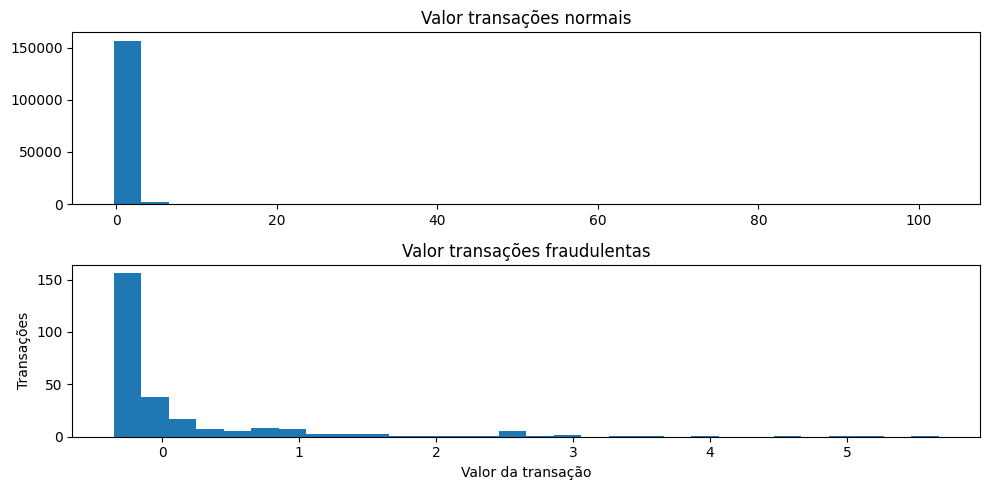

In [36]:
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,5))
numbins=30
ax[0].hist(dftreino.Amount[dftreino.Class==0],bins= numbins)
ax[0].set_title("Valor transações normais")
ax[1].hist(dftreino.Amount[dftreino.Class==1],bins=numbins)
ax[1].set_title("Valor transações fraudulentas")
plt.xlabel("Valor da transação")
plt.ylabel("Transações")
plt.tight_layout()
plt.show()

Como pode-se perceber, possuimos uma distribuição distinta para cada classe, logo, poderá ser fundamental para a criação do nosso modelo

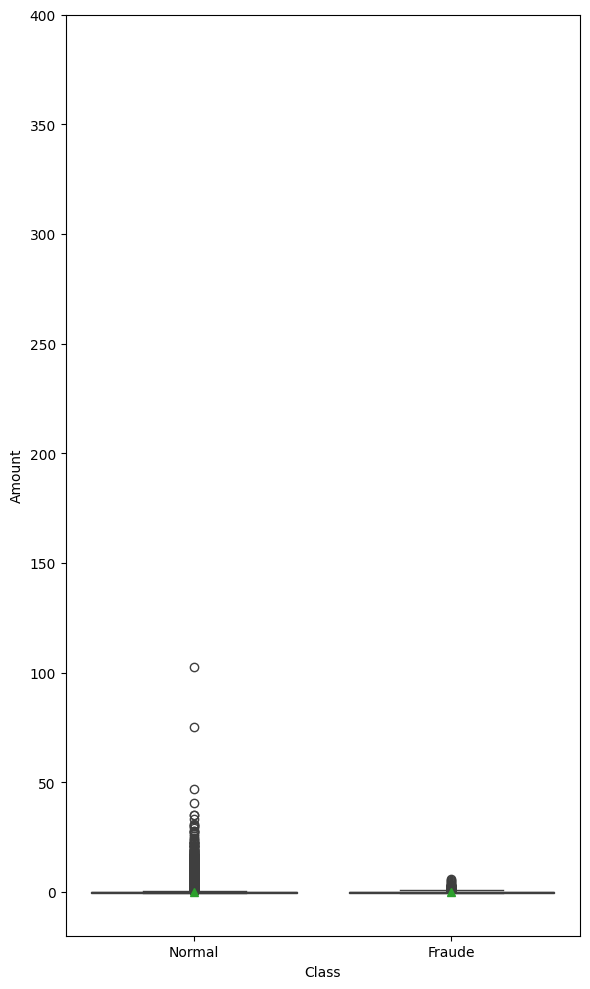

In [35]:
fig, ax = plt.subplots(figsize=(6,10), sharex=True)

sns.boxplot(x='Class', y='Amount', data=dftreino, showmeans=True)
plt.ylim((-20, 400))
plt.xticks([0, 1], ['Normal', 'Fraude'])

plt.tight_layout()

###Correlação entre as variáveis

Para verificar a correlação das variáveis faremos uma matriz de correlação.

Vemos que com os dados da forma que estão (desbalanceados e despadronizados), pouco se tem de correlação entre as *features*




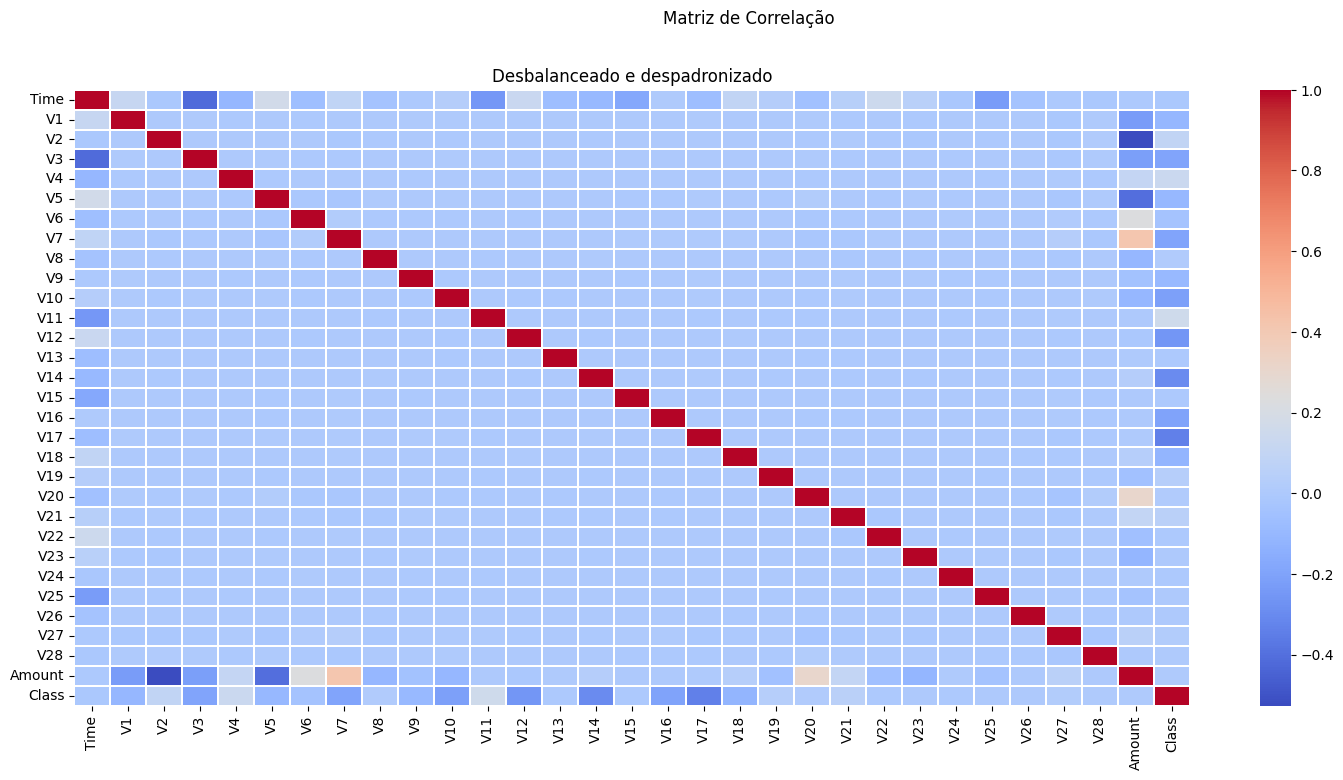

In [37]:
# plotar a matriz de correlação
corr = dftreino.corr()

fig, ax = plt.subplots(nrows=1, figsize = (18,8))
fig.suptitle('Matriz de Correlação')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax)
ax.set_title('Desbalanceado e despadronizado')
plt.show()

### Verificando distribuições de $[V1,V2,...,V28]$

Plotaremos os histogramas de cada uma das variáveis em questão, a fim de entender ao menso o comportamento de cada.




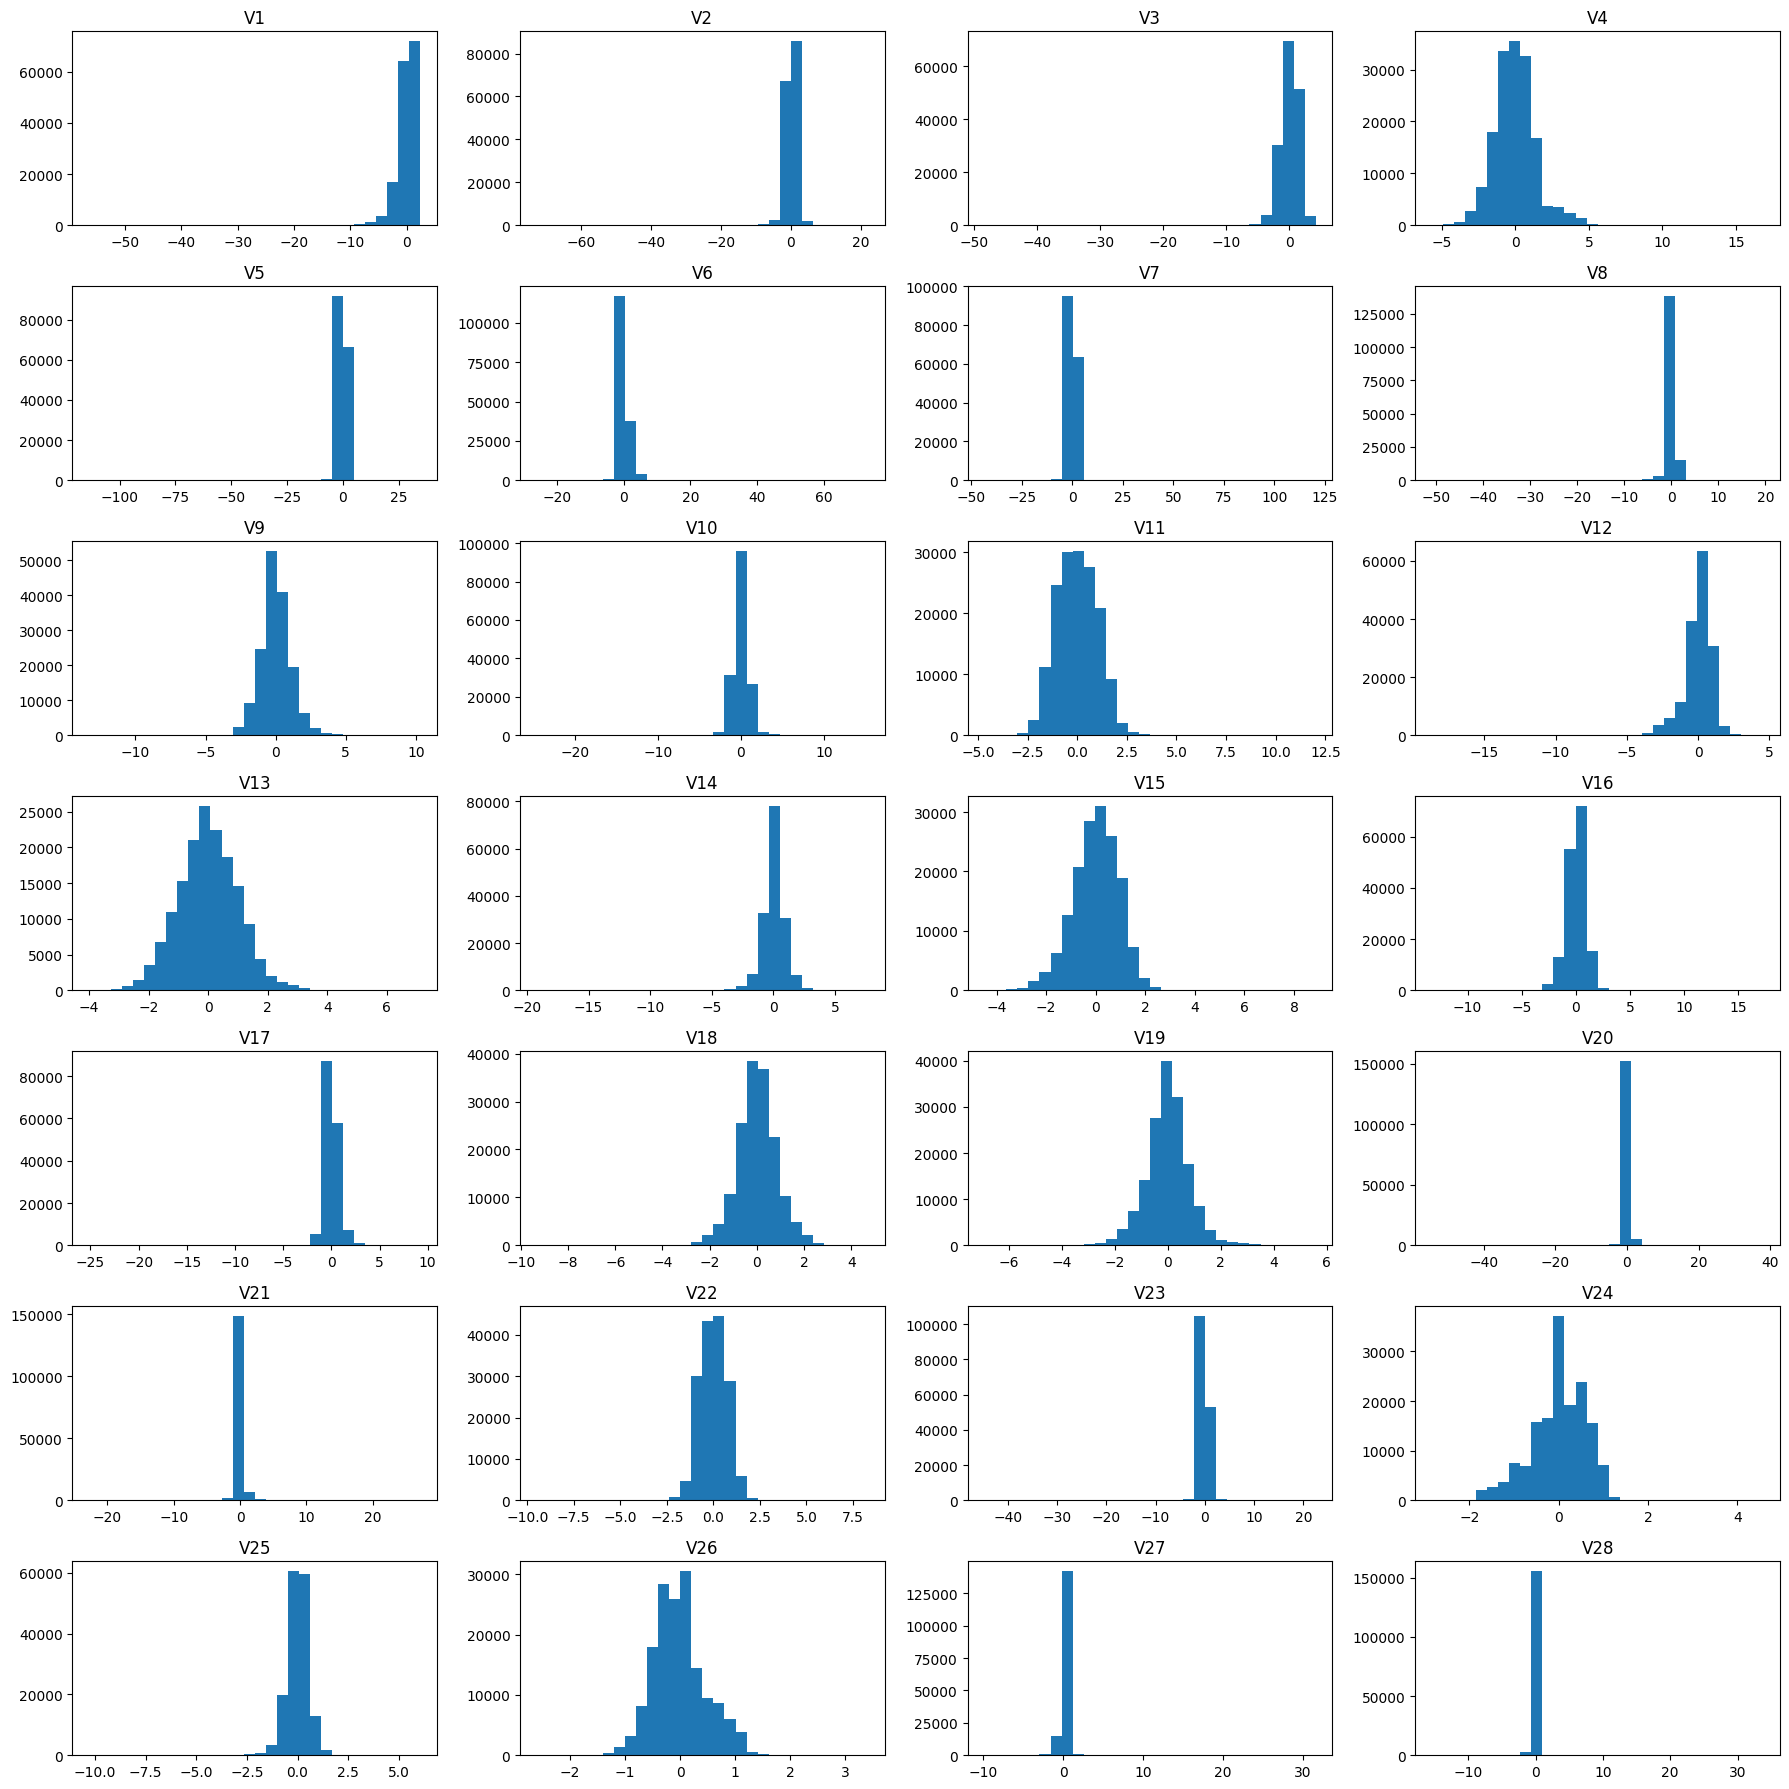

In [38]:
fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))

cols = dftreino.drop(['Time', 'Amount', 'Class'], axis=1).columns
ax = ax.flatten()
for i,col in enumerate(cols):
  ax[i].hist(dftreino[col],bins=30)
  ax[i].set_title(col)
  plt.tight_layout()

Parecem estar normalizadas.

Com a análise exploratória temos:

* O *dataset* possui nenhum valor nulo.
* Temos um grande desbalanceamento .
* `[V1,V2,...,V28]` Não possuem correlação e assume-se que estão normalizadas pois são provindas de PCA.
* `Amount` e `Time` não estão normalizadas

##Processamento dos Dados
Aqui iremos realizar métodos de Balanceamento, criaremos o conjunto de validação e normalização das variáveis


###Normalização de `Time` e `Amount`

É necessário este passo, uma vez que ambas variáveis possuem seus respectivos domínios, assim se não realizarmos este procedimento, nosso modelo dará mais importância para certas variáveis, mas acontecerá somente por estarem em escalas distintas.

In [17]:
dftreino_clean = dftreino.copy()

std_scaller = StandardScaler()
dftreino_clean["Time"] = std_scaller.fit_transform(dftreino_clean[["Time"]])
dftreino_clean["Amount"] = std_scaller.fit_transform(dftreino_clean[["Amount"]])


###Conjunto de Treino e Validação

É importante a criação do conjunto de Validação, uma vez que teremos que selecionar nossos hiperparametros do modelo

In [18]:
X=dftreino_clean.drop("Class",axis=1)
y=dftreino_clean["Class"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123,stratify=y, shuffle=True)
print("Tamanho do conjunto de treino: ",X_train.shape[0])
print("Tamanho do conjunto de validação: ",X_val.shape[0])

Tamanho do conjunto de treino:  159491
Tamanho do conjunto de validação:  39873


###Balanceando o *dataset*

Usaremos o método SMOTETomek

O método consiste em criar amostras artifícias mas com um detalhe de retirar pares ambíguos.

Gostaria de usar o SMOTEENN, mas o peso computacional o inviabilizou.


In [19]:
smote_tomek = SMOTETomek(random_state=123)

X_res,y_res =smote_tomek.fit_resample(X_train,y_train)

In [20]:
print("Novo tamanho do teste:",X_res.shape[0])
print("Tamanho antigo do teste:",X_train.shape[0])

Novo tamanho do teste: 318450
Tamanho antigo do teste: 159491


Veja que realmente balanceamos nosso *dataset*

[]

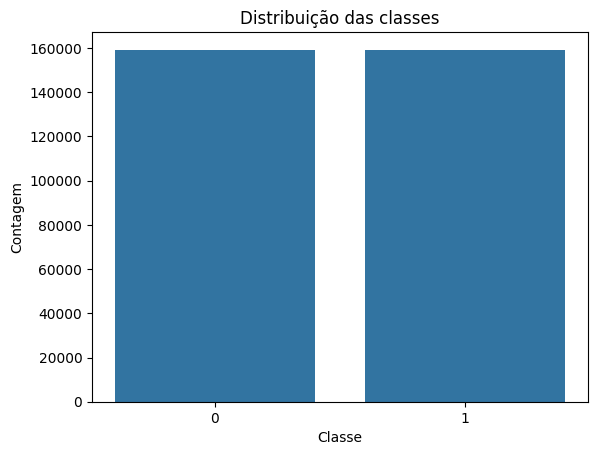

In [21]:
fig, ax = plt.subplots()

sns.countplot(x=y_res, ax=ax)
ax.set_title("Distribuição das classes")
ax.set_xlabel("Classe")
ax.set_ylabel("Contagem")
plt.plot()


Veja que com o balanceamento a matriz de correlação trás mais informações a respeito das variáveis

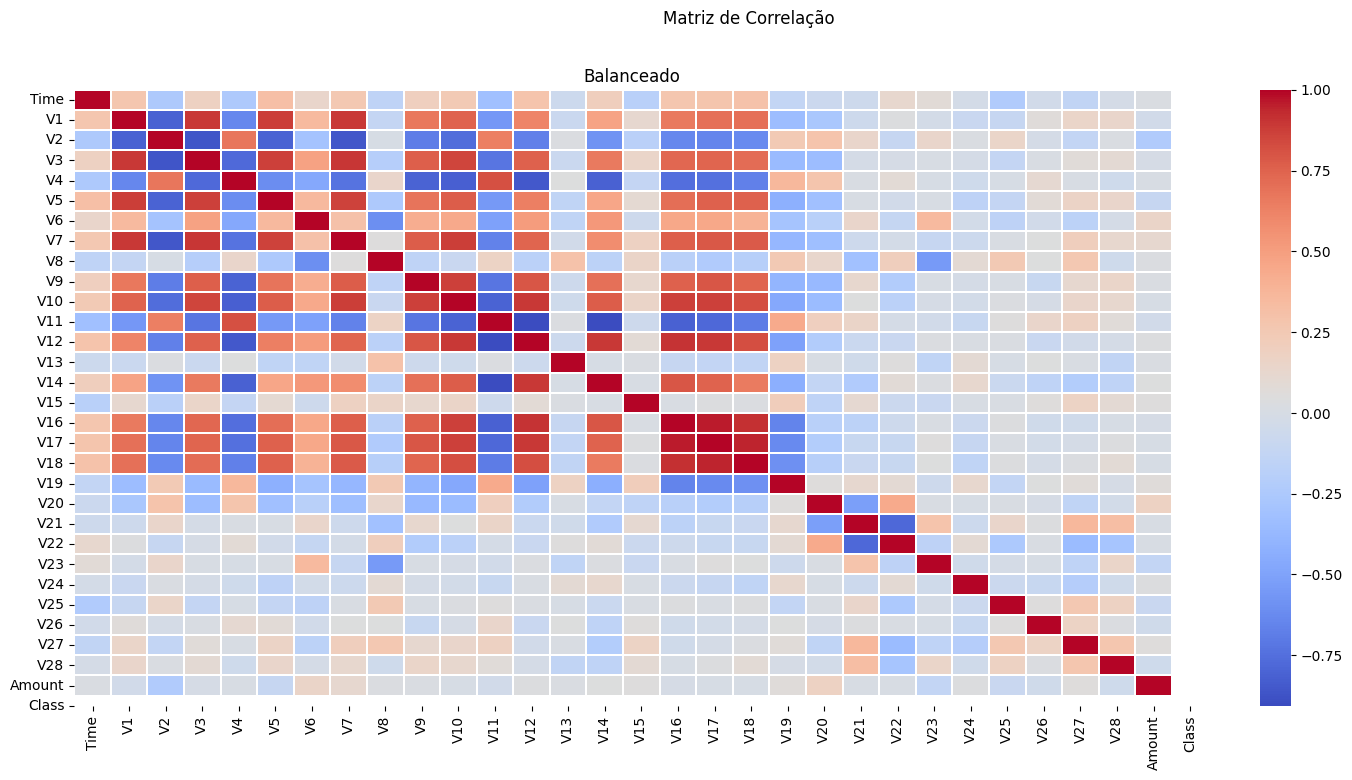

In [22]:
# plotar a matriz de correlação
corr_res = pd.DataFrame(X_res).corr()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (18,8))
fig.suptitle('Matriz de Correlação')
sns.heatmap(corr_res, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax)
ax.set_title('Balanceado')
plt.show()

##Modelagem dos dados

Agora com nosso *dataset* já balanceado, iremos começar a modelar, utilizaremos a regressão logística para nosso problema de classificação, usaremos o conjunto de validação para escolher os melhores hiperparametros.

Iremos utilizar como métrica acertar os dados que sao fraudulentos, então queremos minimizar o erro do tipo aceitar que é boa mas é fraudulenta, como boa é nosso negativo, queremos minimizar o erro do tipo Falso Negativo, assim utilizaremos o recall.

Claro que, temos um trade-off, algumas compras que são boas serão canceladas, mas veja que estamos lidando com um grupo que não podemos errar, então sigo com essa métrica


In [25]:
#Modelo
model = LogisticRegression()

#Hiperparametros testados
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear'],
    'class_weight': [None],
    'max_iter': [100, 200, 500]
}

#K-fold
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

#Aplica o ajuste nos dados de treino
grid_search.fit(X_res, y_res)

#Melhor modelo encontrado
best_model = grid_search.best_estimator_
print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

#Avaliação no conjunto de validação
val_score = best_model.score(X_val, y_val)
print(f"Recall na validação: {val_score:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores hiperparâmetros encontrados:
{'C': 10, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Recall na validação: 0.9709


Temos então que nosso melhor modelo foi: {'C': 10, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

Com Recall de 0.9709

##Aplicando o Modelo no conjunto de Testes

Agora com nosso modelo ja validado, iremos aplicar no Conjunto de teste, simulando a entrada de dados novos.


Antes de aplicarmos diretamente, temos que tratar `Time` e `Amount`, pois nosso modelo está utilizando os valores deles já normalizados. Se não normalizarmos, nosso modelo estará utilizando valores diferentes do treinado.

In [41]:
dfteste = pd.concat([X_test,y_test],axis=1)
std_scaller = StandardScaler()
dfteste["Time"] = std_scaller.fit_transform(dfteste[["Time"]])
dfteste["Amount"] = std_scaller.fit_transform(dfteste[["Amount"]])


Com nossos novos dados já tratados, iremos aplicar o modelo treinado

In [43]:
X_test = dfteste.drop("Class",axis=1)
y_test = dfteste["Class"]

In [45]:
y_pred = best_model.predict(X_test)

Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.9998    0.9714    0.9854     85283
           1     0.0569    0.9187    0.1072       160

    accuracy                         0.9713     85443
   macro avg     0.5284    0.9451    0.5463     85443
weighted avg     0.9981    0.9713    0.9838     85443



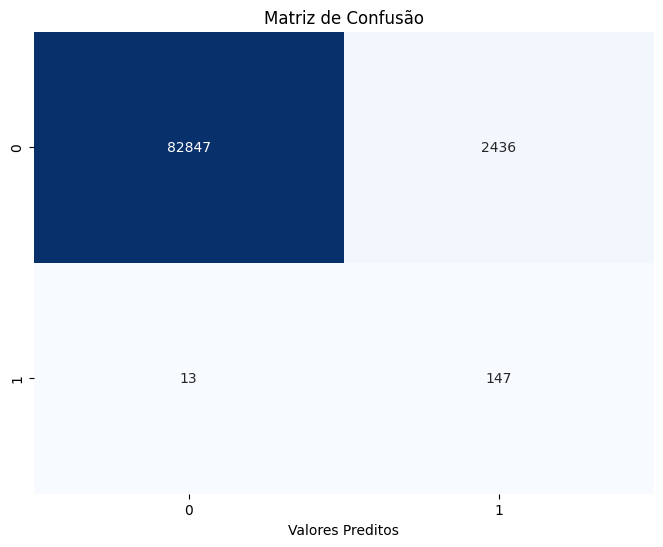

In [58]:
matriz_conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.xlabel('Valores Preditos')
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, digits=4))


##Conclusão

Obtivemos um recall próximo do nosso de validação: val = 0.9709, teste= 0.9714.

Dos `160 casos fraudulentos`, acertamos `147` deles, apenas `13` *(0,08125)* casos foram considerados como boas compras mas na verdade eram fraudulentos.

Como podemos ver, tal foco  em não aceitar compras fraudulentas, causou um número de 2436 compras boas consideradas como fraudulentas. Nesse caso, o cliente apenas sofreu uma pequena dor de cabeça.


Obviamente, este projeto está em cima de dados de fácil acesso e que ja tiveram algum tipo de tratamento(PCA e Ausência de Valores-Nulos), mas ainda sim se trata de um problema interessante, visto que são dados extremamente desbalanceados e possuem uma importância crucial para as empresas financeiras.

Por mais que tenha obtido um bom resultado seguindo minha lógica de negócio(diminuir compras fraudulentas que se passam por boas), há espaço para melhorar o modelo, (tentar outros modelos de classificação e novos balanceamentos).

Agradeço a todos que tiraram seu próprio tempo lendo um pouco do meu projeto, e qualquer dúvida podem entrar em contato comigo pelo meu email: pedropm@id.uff.br.
